In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import numpy as np
import math

import mplfinance as mplf

import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mplfinance.original_flavor import candlestick_ohlc

In [2]:
def get_stock_price(symbol, period='5d', interval='60m'):
    
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    
    df = yf.download(symbol, period=period, interval=interval, threads= False)
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
    return df

In [3]:
class FractalPattern():
    def __init__(self, df):
        self.df = df
        
    def plot_(self):
        self.plot_all(self.get_levels(self.df), self.df)
        
    def is_support(self, df,i):
        cond1 = df['Low'][i] < df['Low'][i-1] 
        cond2 = df['Low'][i] < df['Low'][i+1] 
        cond3 = df['Low'][i+1] < df['Low'][i+2] 
        cond4 = df['Low'][i-1] < df['Low'][i-2]
        return (cond1 and cond2 and cond3 and cond4)

    def is_resistance(self, df,i):
        cond1 = df['High'][i] > df['High'][i-1] 
        cond2 = df['High'][i] > df['High'][i+1] 
        cond3 = df['High'][i+1] > df['High'][i+2] 
        cond4 = df['High'][i-1] > df['High'][i-2]
        return (cond1 and cond2 and cond3 and cond4)

    def is_far_from_level(self, value, levels, df):
        ave =  np.mean(df['High'] - df['Low'])
        return np.sum([abs(value - level) < ave for _, level in levels]) == 0

    def plot_all(self, levels, df):
        fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
        
        candlestick_ohlc(
            ax,df.values,
            width=0.1*(mdates.date2num(df.index[1])-mdates.date2num(df.index[0])), 
            colorup='green', 
            colordown='red', 
            alpha=0.8
        )

        date_format = mpl_dates.DateFormatter('%d %b %Y')
        ax.xaxis.set_major_formatter(date_format)
        for level in levels:
            plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linestyle='--', linewidths=1)

    def get_levels(self, df):
        levels = []
        for i in range(2,len(df)-2):
            if self.is_support(df,i):
                l = df['Low'][i]
                if self.is_far_from_level(l, levels, df):
                    levels.append((i,l))
            elif self.is_resistance(df,i):
                l = df['High'][i]
                if self.is_far_from_level(l, levels, df):
                    levels.append((i,l))
        return levels


In [4]:
class WindowShiftingPattern(FractalPattern):
    def __init__(self, df):
        self.df = df
    
    def plot_(self):
        pivots = []
        max_list = []
        min_list = []
        for i in range(5, len(df)-5):
            high_range = df['High'][i-5:i+4]
            current_max = high_range.max()

            if current_max not in max_list:
                max_list = []
            max_list.append(current_max)
            if len(max_list) == 5 and self.is_far_from_level(current_max, pivots, df):
                pivots.append((high_range.idxmax(), current_max))

            low_range = df['Low'][i-5:i+5]
            current_min = low_range.min()
            if current_min not in min_list:
                min_list = []
            min_list.append(current_min)
            if len(min_list) == 5 and self.is_far_from_level(current_min, pivots, df):
                pivots.append((low_range.idxmin(), current_min))

        self.plot_all(pivots, df)


[*********************100%***********************]  1 of 1 completed


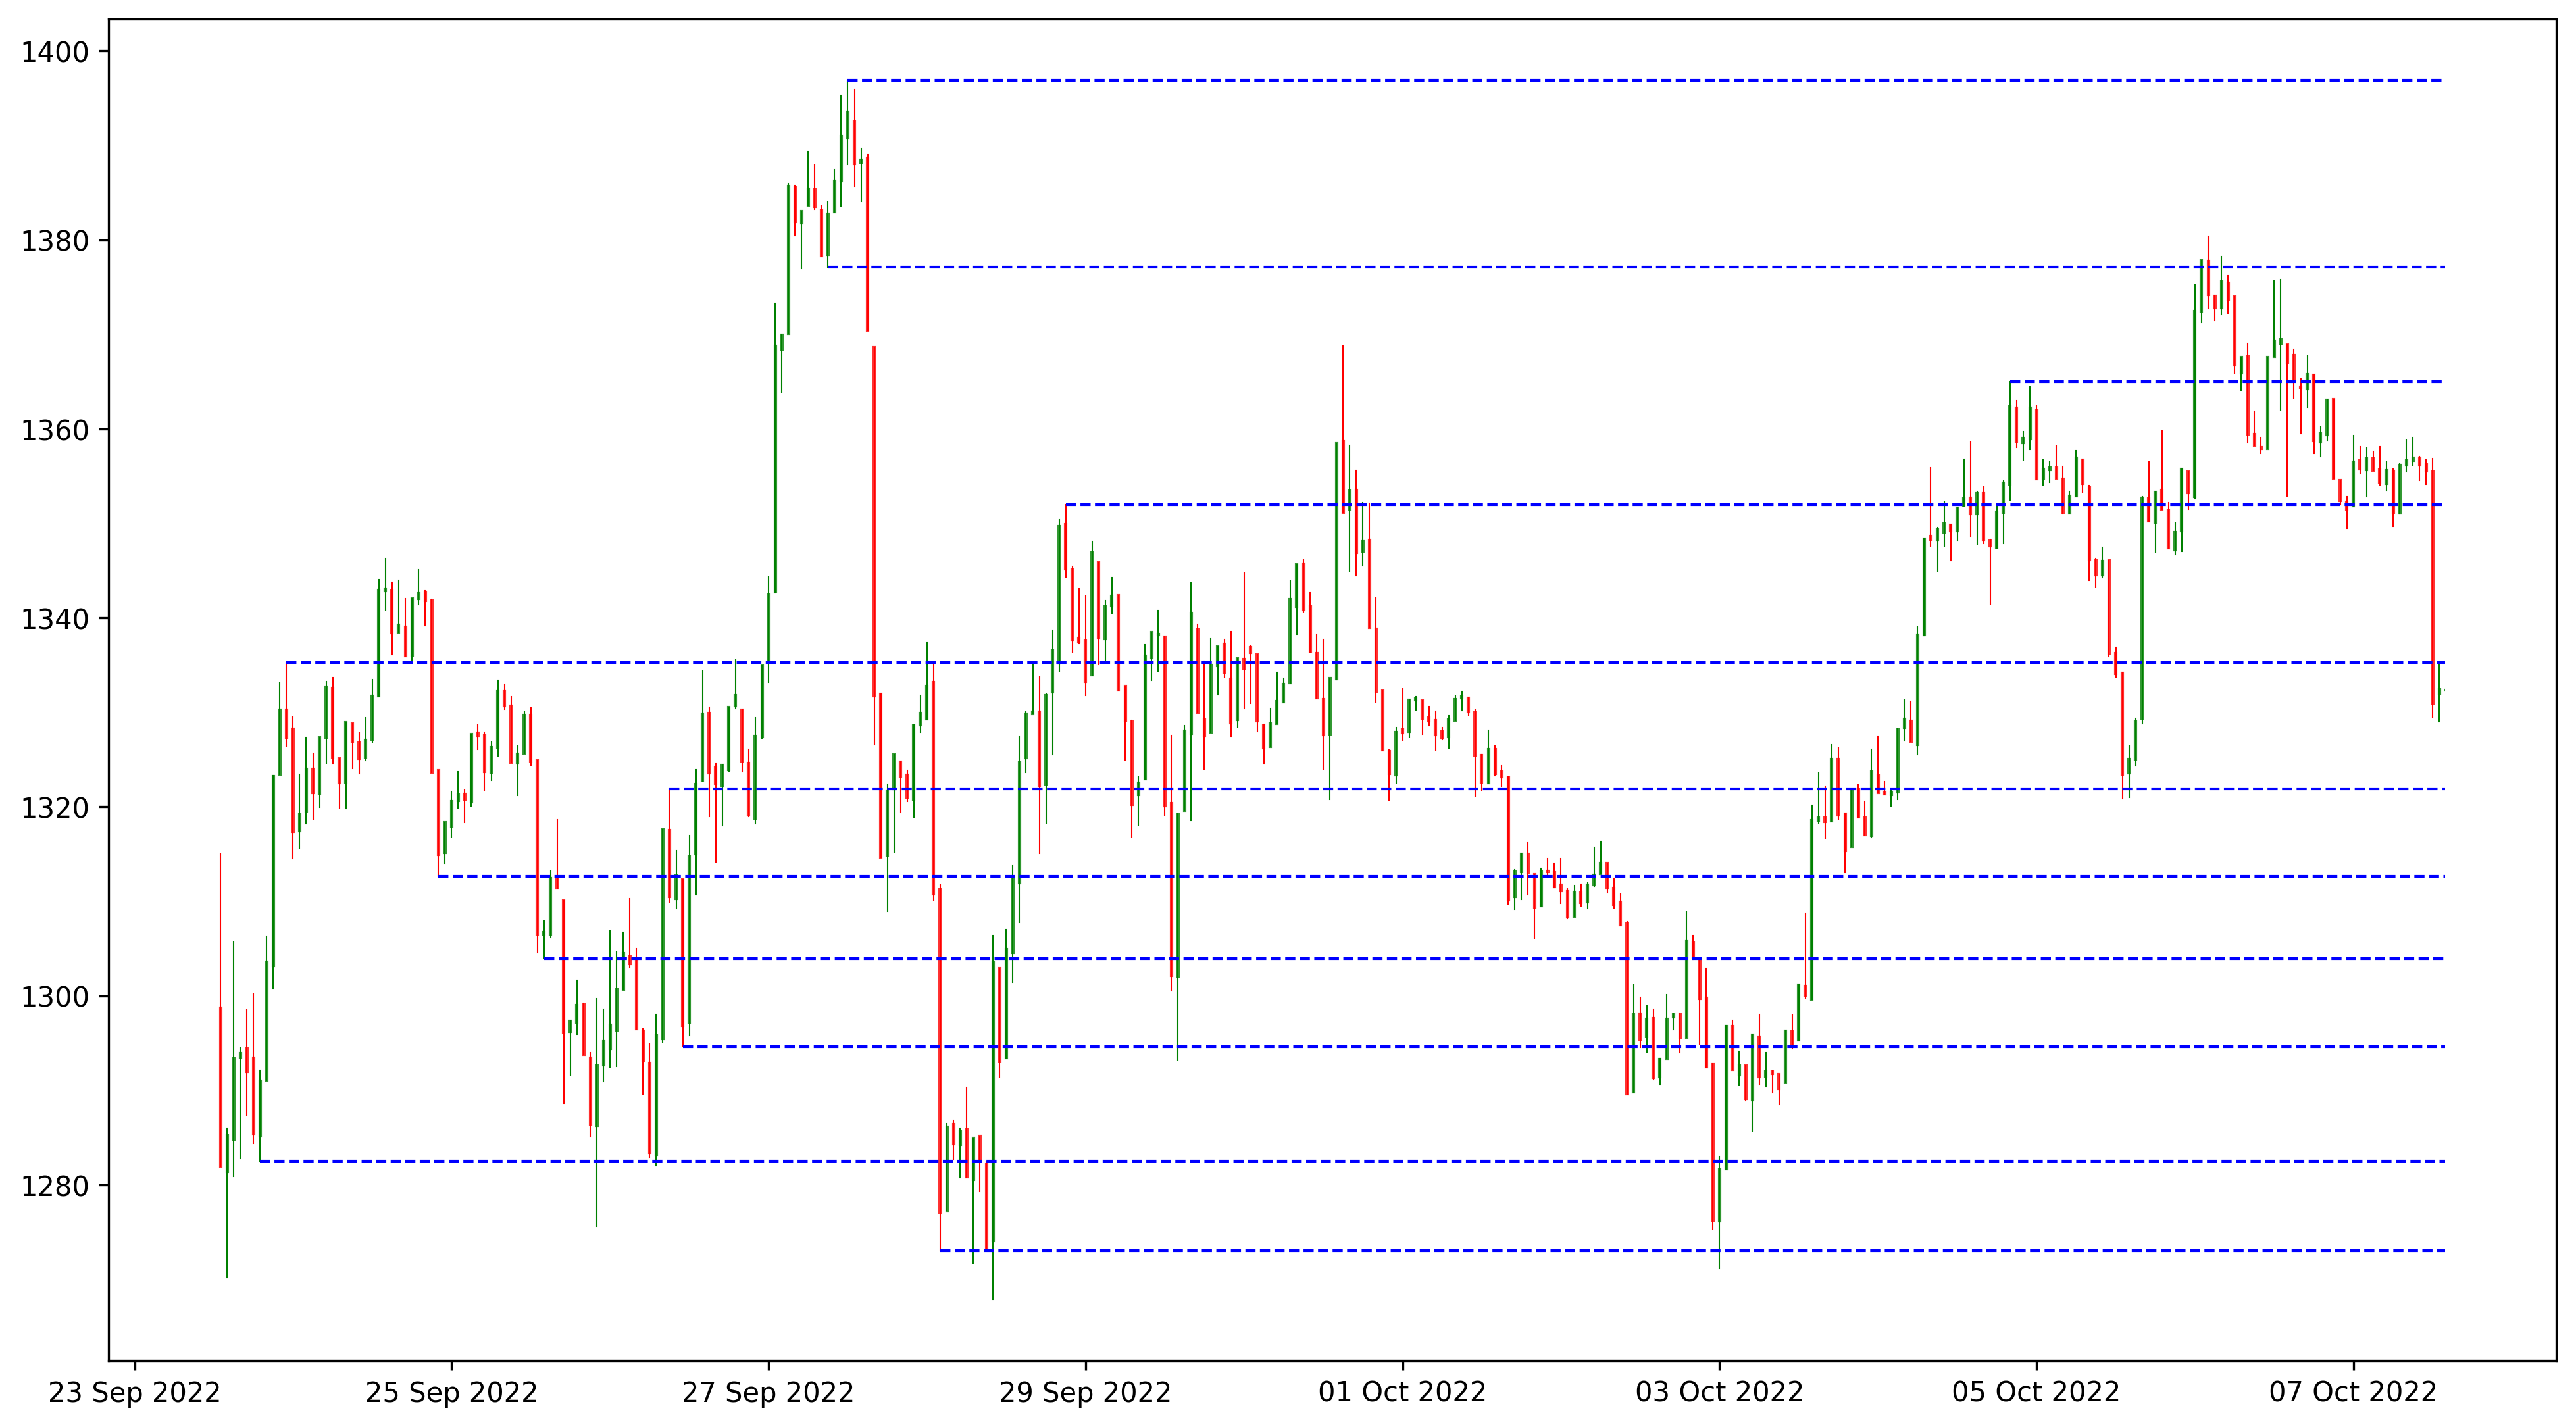

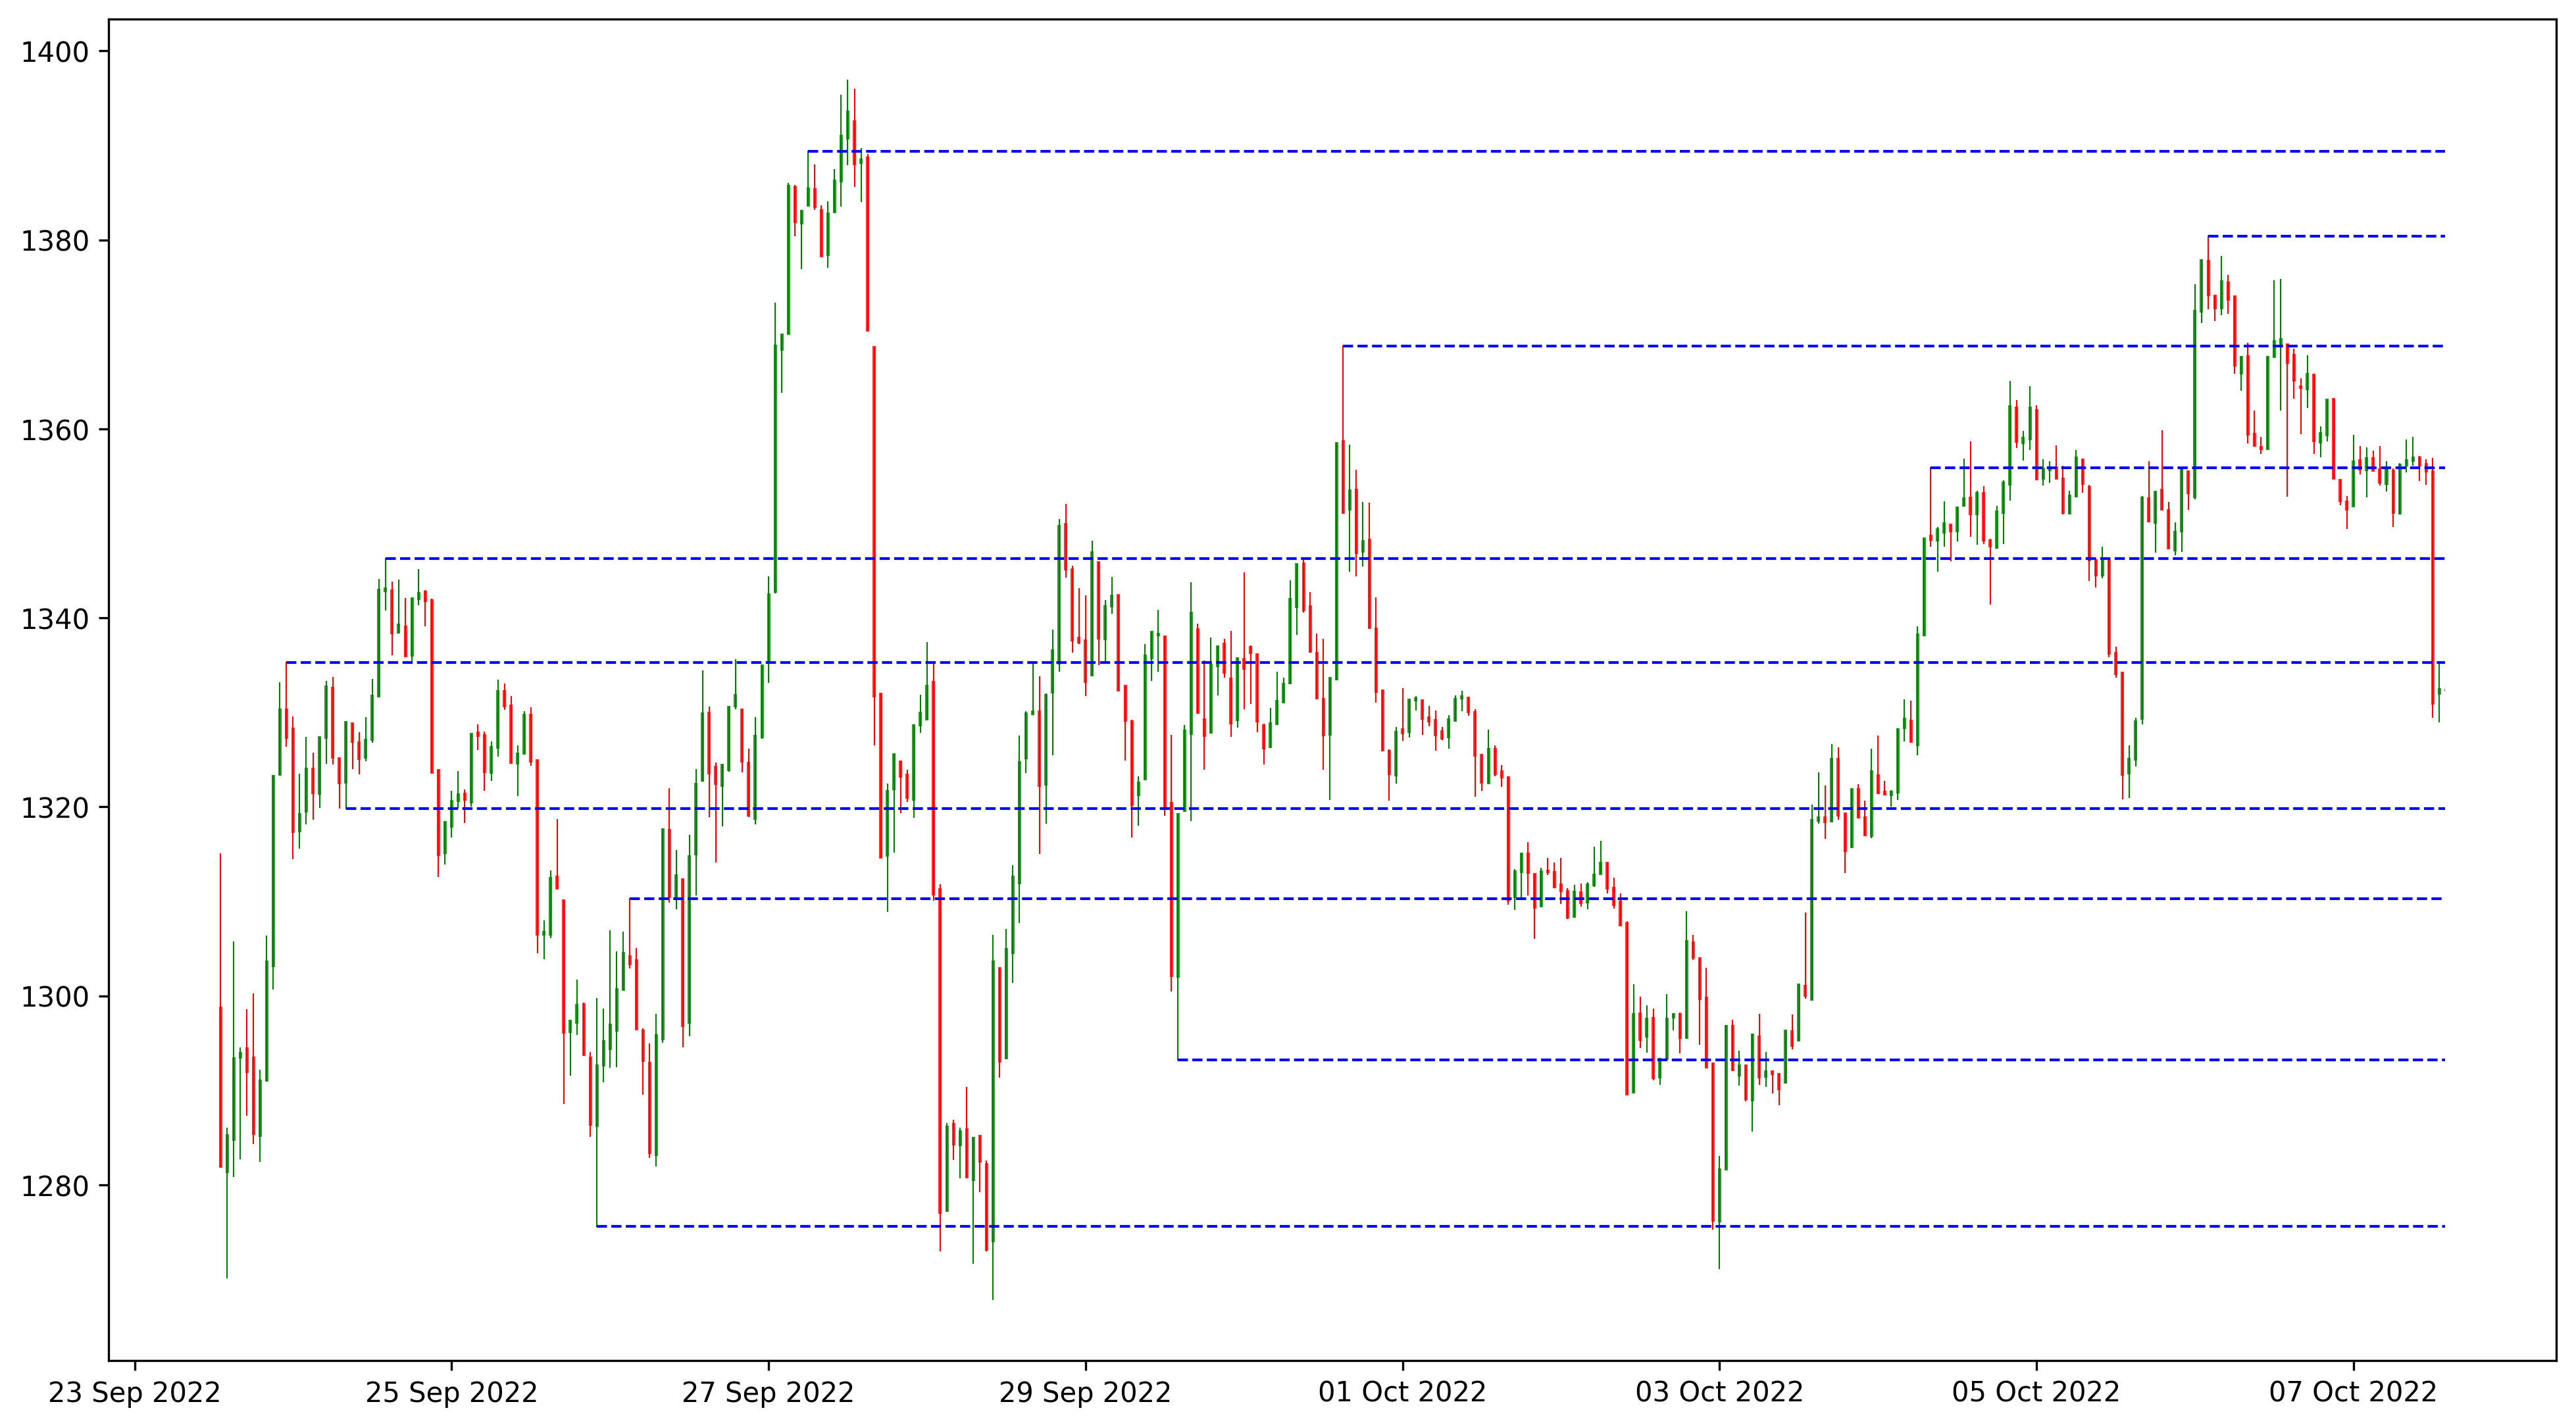

In [5]:
df = get_stock_price("ETH-USD", period="2wk", interval="1h")
FractalPattern(df).plot_()
WindowShiftingPattern(df).plot_()